In [1]:
import sys
import numpy as np 
import pandas as pd 
from tensorflow import keras
import matplotlib.pyplot as plt
import IPython 
from cond_rnn import ConditionalRecurrent

In [2]:
#load sequence data for task 3
path_01 = 'dataset/data_seq'
x_train = np.load(path_01 + '/x_train.npy')
x_test = np.load(path_01 + '/x_test.npy')
x_valid = np.load(path_01 + '/x_valid.npy')
y_train_seq = np.load(path_01 + '/y_train.npy')
y_test_seq = np.load(path_01 + '/y_test.npy')
y_valid_seq = np.load(path_01 + '/y_valid.npy')

#removing variables

#0:'Max_Draught'
#1: 'Latitude'
#2: 'Longitude'
#3: 'Speed_over_Ground'
#4: 'COG_cos'
#5: 'COG_sin'
#6: 'TH_cos'
#7: 'TH_sin'
#8: 'Navigational_Status_0.0'
#9: 'Navigational_Status_1.0'
#10: 'Navigational_Status_2.0'
#11: 'Navigational_Status_3.0'
#12: 'Navigational_Status_4.0'
#13: 'Na13vigational_Status_5.0'
#14: 'Nav14igational_Status_8.0'
#15: 'Navi15gational_Status_15.0'
#16: 'GT'
#17: 'DWT'
#18: 'LOA'
#19: 'BEAM'
#20: 'VesselTypeB_Cargo'
#21: 'VesselTypeB_Tanker'
#22: 'Age'
#23: 'current_utotal' 
#24: 'current_vtotal'
#25: 'wind_u10'
#26: 'wind_v10'
#27: 'mwd' 
#28: 'mwp' 
#29: 'swh'
#30: 'sst'  
#31: 'Origin_Lat'
#32: 'Origin_Lon'
#33: 'acc_dist' 
#34: 'acc_time_hours'
#35: 'leg_distance'
#36: 'leg_speed'
#37: 'leg_elapsed_time_hours'
#38: 'remaining_distance'


x_train_seq= np.delete(x_train,[23,24,25,26,27,28,29,30],2)
x_test_seq= np.delete(x_test,[23,24,25,26,27,28,29,30],2)
x_valid_seq= np.delete(x_valid,[23,24,25,26,27,28,29,30],2)

print('x_train_seq shape:', x_train_seq.shape)
print('y_train_seq shape:', y_train_seq.shape)
print('x_valid_seq shape:', x_valid_seq.shape)
print('y_valid_seq shape:', y_valid_seq.shape)
print('x_test_seq shape:', x_test_seq.shape)
print('y_test_seq shape:', y_test_seq.shape)

n_features = x_train_seq.shape[2]
steps = x_train_seq.shape[1]
print('n_features = ', n_features)
print('steps = ', steps)

x_train_seq shape: (1417, 65, 31)
y_train_seq shape: (1417, 65, 1)
x_valid_seq shape: (709, 65, 31)
y_valid_seq shape: (709, 65, 1)
x_test_seq shape: (708, 65, 31)
y_test_seq shape: (708, 65, 1)
n_features =  31
steps =  65


In [3]:
#separate sequential and non-sequential data
x_train_nn_cc= np.delete(x_train,[16,17,18,19,20,21,22,31,32,23,24,25,26,27,28,29,30],2)
x_test_nn_cc= np.delete(x_test,[16,17,18,19,20,21,22,31,32,23,24,25,26,27,28,29,30],2)
x_valid_nn_cc= np.delete(x_valid,[16,17,18,19,20,21,22,31,32,23,24,25,26,27,28,29,30],2)

x_train_cc_split= np.delete(x_train,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,23,24,25,26,27,28,29,30,33,34,35,36,37,38],2)
x_test_cc_split= np.delete(x_test,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,23,24,25,26,27,28,29,30,33,34,35,36,37,38],2)
x_valid_cc_split= np.delete(x_valid,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,23,24,25,26,27,28,29,30,33,34,35,36,37,38],2)


print('x_train_nn_cc shape:', x_train_nn_cc.shape)
print('x_valid_nn_cc shape:', x_valid_nn_cc.shape)
print('x_test_nn_cc shape:', x_test_nn_cc.shape)
print('')
print('x_train_cc shape:', x_train_cc_split.shape)
print('x_valid_cc shape:', x_valid_cc_split.shape)
print('x_test_cc shape:', x_test_cc_split.shape)

n_features_nn_cc = x_train_nn_cc.shape[2]
n_features_cc = x_train_cc_split.shape[2]
steps = x_train.shape[1]
print('n_features_nn_cc = ', n_features_nn_cc)
print('n_features_cc = ', n_features_cc)
print('steps = ', steps)

x_train_nn_cc shape: (1417, 65, 22)
x_valid_nn_cc shape: (709, 65, 22)
x_test_nn_cc shape: (708, 65, 22)

x_train_cc shape: (1417, 65, 9)
x_valid_cc shape: (709, 65, 9)
x_test_cc shape: (708, 65, 9)
n_features_nn_cc =  22
n_features_cc =  9
steps =  65


In [4]:
#put non-sequential data into the right shape
def get_cc_data(data):
  X = []
  for i in range(data.shape[0]):
    x = data[i,0,:]
    x = x.reshape (1,n_features_cc) 
    X.append(x)
  X = np.array(X).reshape(data.shape[0],data.shape[2])
  return X  

x_train_cc = get_cc_data(x_train_cc_split)
x_valid_cc = get_cc_data(x_valid_cc_split)
x_test_cc = get_cc_data(x_test_cc_split) 

In [5]:
#load non sequence data and keep variables for inputs set: AIS + Vessel particulars + Crafted features
path_02 = 'dataset/data_nn_seq'
x_train_nn_seq = np.load(path_02 + '/x_train.npy')
x_test_nn_seq = np.load(path_02 + '/x_test.npy')
x_valid_nn_seq = np.load(path_02 + '/x_valid.npy')
y_train_nn_seq = np.load(path_02 + '/y_train.npy')
y_test_nn_seq = np.load(path_02 + '/y_test.npy')
y_valid_nn_seq = np.load(path_02 + '/y_valid.npy')

#removing variables
x_train_nn_seq= np.delete(x_train_nn_seq,[23,24,25,26,27,28,29,30],1)
x_test_nn_seq= np.delete(x_test_nn_seq,[23,24,25,26,27,28,29,30],1)
x_valid_nn_seq= np.delete(x_valid_nn_seq,[23,24,25,26,27,28,29,30],1)

print('x_train_nn_seq shape:', x_train_nn_seq.shape)
print('y_train_nn_seq shape:', y_train_nn_seq.shape)
print('x_valid_nn_seq shape:', x_valid_nn_seq.shape)
print('y_valid_nn_seq shape:', y_valid_nn_seq.shape)
print('x_test_nn_seq shape:', x_test_nn_seq.shape)
print('y_test_nn_seq shape:', y_test_nn_seq.shape)

x_train_nn_seq shape: (77122, 31)
y_train_nn_seq shape: (77122, 1)
x_valid_nn_seq shape: (38835, 31)
y_valid_nn_seq shape: (38835, 1)
x_test_nn_seq shape: (39777, 31)
y_test_nn_seq shape: (39777, 1)


In [6]:
#load sequences length
train_seq_len = np.load(path_01 + '/train_sequence_length.npy')
valid_seq_len = np.load(path_01+ '/valid_sequence_length.npy')
test_seq_len = np.load(path_01 + '/test_sequence_length.npy')
#load remaining_time metrics
rem_dist_train_std = np.load(path_01 + '/remaining_distance_std_train.npy')
rem_dist_train_mean = np.load(path_01 + '/remaining_distance_mean_train.npy')

In [7]:
#get a list of remaining distances from sequence data

test_seq = np.load(path_01 + '/x_test.npy')

def get_distance_arr(x_data, seq_len):
  distance = []
  for i in range(x_data.shape[0]):
    z = seq_len[i]
    d = x_data[i,:z,-1]
    d = d.tolist()
    distance.extend(d)
  return distance

#get the list for tests 
distance_seq_test = get_distance_arr(test_seq, test_seq_len)
distance_seq_rev_test = [(item*rem_dist_train_std)+rem_dist_train_mean for item in distance_seq_test]
distance_seq_rev_test = [max(num, 0) for num in distance_seq_rev_test]


#load non sequence data and get unscaled remaining distance list 
test_nn_seq = np.load(path_02 + '/x_test.npy')

distance_nn_seq_test = test_nn_seq[:,-1]
distance_nn_seq_rev_test = [(item*rem_dist_train_std) + rem_dist_train_mean for item in distance_nn_seq_test]
distance_nn_seq_rev_test = [max(num, 0) for num in distance_nn_seq_rev_test]

In [8]:
#load the models
models_path = '/content/drive/MyDrive/ETA_Project/Papers/Article_FMSJ_Submission_Dec_2021/Paper_Revision/ETA_Models/models/models_performance/best_models/'
lstm3 = keras.models.load_model(models_path + 'lstm3.h5', custom_objects={'ConditionalRecurrent': ConditionalRecurrent})
cnn3 = keras.models.load_model(models_path + 'cnn3.h5')
wavenet3 = keras.models.load_model(models_path + 'wavenet3.h5')
mlp3 = keras.models.load_model(models_path + 'mlp3.h5')

##1-Models' performance and architecture:

In [9]:
#MSE and MAE evaluation on train, validation and test sets
print('LSTM:')
print('Train set performance:', lstm3.evaluate([x_train_nn_cc, x_train_cc], y_train_seq, verbose=0))
print('Validation set performance:', lstm3.evaluate([x_valid_nn_cc, x_valid_cc], y_valid_seq, verbose=0))
print('Test set performance:', lstm3.evaluate([x_test_nn_cc, x_test_cc], y_test_seq, verbose=0))
print('1D-CNN:')
print('Train set performance:', cnn3.evaluate([x_train_nn_cc, x_train_cc], y_train_seq, verbose=0))
print('Validation set performance:', cnn3.evaluate([x_valid_nn_cc, x_valid_cc], y_valid_seq, verbose=0))
print('Test set performance:', cnn3.evaluate([x_test_nn_cc, x_test_cc], y_test_seq, verbose=0))
print('WAVENET:')
print('Train set performance:', wavenet3.evaluate([x_train_nn_cc, x_train_cc], y_train_seq, verbose=0))
print('Validation set performance:', wavenet3.evaluate([x_valid_nn_cc, x_valid_cc], y_valid_seq, verbose=0))
print('Test set performance:', wavenet3.evaluate([x_test_nn_cc, x_test_cc], y_test_seq, verbose=0))
print('MLP:')
print('Train set performance:', mlp3.evaluate(x_train_nn_seq, y_train_nn_seq, verbose=0))
print('Validation set performance:', mlp3.evaluate(x_valid_nn_seq, y_valid_nn_seq, verbose=0))
print('Test set performance:', mlp3.evaluate(x_test_nn_seq, y_test_nn_seq, verbose=0))

LSTM:
Train set performance: [52.12046432495117, 3.1452770233154297]
Validation set performance: [71.919189453125, 3.5308661460876465]
Test set performance: [66.96340942382812, 3.533939838409424]
1D-CNN:
Train set performance: [59.419097900390625, 3.6694536209106445]
Validation set performance: [75.29751586914062, 3.9830269813537598]
Test set performance: [65.08674621582031, 3.9771199226379395]
WAVENET:
Train set performance: [51.63508987426758, 3.321486234664917]
Validation set performance: [72.72404479980469, 3.8429291248321533]
Test set performance: [63.688053131103516, 3.8004162311553955]
MLP:
Train set performance: [95.37124633789062, 5.779638290405273]
Validation set performance: [103.43861389160156, 6.079295635223389]
Test set performance: [86.3079605102539, 5.834592819213867]


In [10]:
print(lstm3.summary())
print(cnn3.summary())
print(wavenet3.summary())
print(mlp3.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 65, 22)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 conditional_recurrent (Conditi  (None, 65, 60)      20520       ['input_1[0][0]',                
 onalRecurrent)                                                   'input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 65, 60)       0           ['conditional_recurrent[0][0]

##2-Predictions vs true targets plots:

In [11]:
#plot y_true vs y_predictions from test set
def plot_y_true_y_pred(name, model, x_test, y_test):
  test_predictions = model.predict(x_test)

  plt.figure(figsize=[2, 2], dpi=150)
  a = plt.axes(aspect='equal')

  plt.scatter(y_test, test_predictions, s=0.1)
  plt.xticks(fontsize=5)
  plt.yticks(fontsize=5)
  plt.xlabel('True Values [hour]', fontsize=7)
  plt.ylabel('Predictions [hour]', fontsize=7)
  plt.title(name, fontsize=8)
  lims = [0, 200]
  plt.xlim(lims)
  plt.ylim(lims)
  _ = plt.plot(lims, lims)


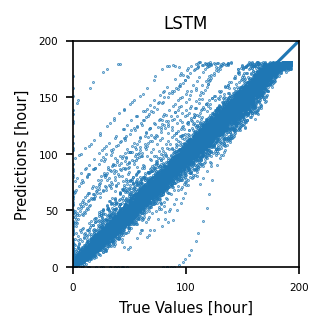

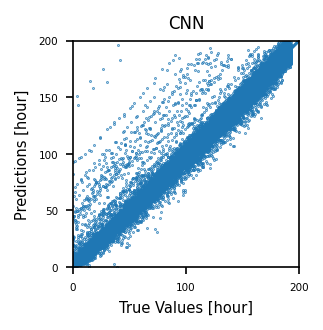

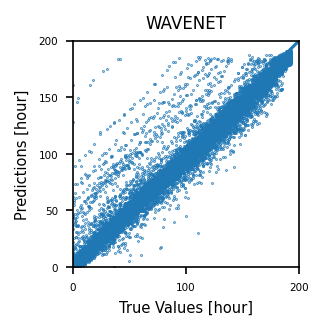

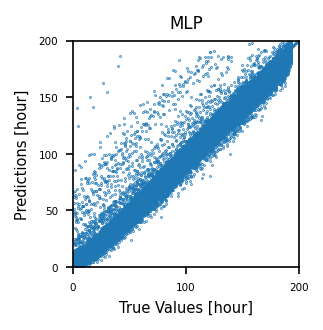

In [12]:
plot_y_true_y_pred('LSTM', lstm3, [x_test_nn_cc, x_test_cc], y_test_seq)
plot_y_true_y_pred('CNN', cnn3, [x_test_nn_cc, x_test_cc], y_test_seq)
plot_y_true_y_pred('WAVENET', wavenet3, [x_test_nn_cc, x_test_cc], y_test_seq)
plot_y_true_y_pred('MLP', mlp3, x_test_nn_seq, y_test_nn_seq)

##3-Error measures per observation for sequence models

In [13]:
#calculate the mse per obseravtion of sequence models for comparison with non sequence models 
def mse_obs(x_data_nn_cc, x_data_cc, y_data, model, seq_len):
  """
    Calculates the mse per observation of the sequence models
    
    Arguments:
    x_data_nn_cc -- sequential data
    x_data_cc -- non sequential data
    y_data -- true target
    model -- predictive model
    seq_len -- the true sequence length of the example

    Returns:
    squared error -- list of mse per observation
    MSE -- mean squared error
    """
    
  squared_error = []

  for i in range(x_data_nn_cc.shape[0]):
    y = y_data[i].reshape(1,steps,1)
    z = seq_len[i]
    y_hat = model.predict([x_data_nn_cc[i].reshape(1,steps,n_features_nn_cc), x_data_cc[i].reshape(1,n_features_cc)])
    error = np.square(y[:,:z,:] - y_hat[:,:z,:])
    error = error.reshape(z)
    error = error.tolist()
    squared_error.extend(error)
 
  return np.mean(squared_error), squared_error

In [14]:
#calculate the MAE per obseravtion of sequence models for comparison with non sequence models 
def mae_obs(x_data_nn_cc, x_data_cc, y_data, model, seq_len) :
  """
    Calculates the mse per observation of the sequence models
    
    Arguments:
    x_data_nn_cc -- sequential data
    x_data_cc -- non sequential data
    y_data -- true target
    model -- predictive model
    seq_len -- the true sequence length of the example

    Returns:
    absolute error -- list of mse per observation
    MAE -- mean absolute error
    """
  absolute_error =[]
  for i in range(x_data_nn_cc.shape[0]):
    y = y_data[i].reshape(1,steps,1)
    z = seq_len[i]
    y_hat = model.predict([x_data_nn_cc[i].reshape(1,steps,n_features_nn_cc),x_data_cc[i].reshape(1,n_features_cc)])
    error = np.abs(y[:,:z,:] - y_hat[:,:z,:])
    error = error.reshape(z)
    error = error.tolist()
    absolute_error.extend(error)
  return np.mean(absolute_error), absolute_error

In [15]:
#calculate MSE and MAE per observations for non sequence model
mlp3_pred = mlp3.predict(x_test_nn_seq)
mlp3_mse = np.square(y_test_nn_seq - mlp3_pred)
mlp3_mae = np.abs(y_test_nn_seq - mlp3_pred)

In [16]:
#calculate mse for sequence models
lstm3_mse_obs = mse_obs(x_test_nn_cc, x_test_cc, y_test_seq, lstm3, test_seq_len)
cnn3_mse_obs = mse_obs(x_test_nn_cc, x_test_cc, y_test_seq, cnn3, test_seq_len)
wavenet3_mse_obs = mse_obs(x_test_nn_cc, x_test_cc, y_test_seq, wavenet3, test_seq_len)

print('The performance metrics on the test set are:')
print('')
print('LSTM_3:')
print('The MSE considering errors per observation:', lstm3_mse_obs[0])
print('')
print('CNN_3:')
print('The MSE considering errors per observation:', cnn3_mse_obs[0])
print('')
print('WAVENET_3:')
print('The MSE considering errors per observation:', wavenet3_mse_obs[0])

The performance metrics on the test set are:

LSTM_3:
The MSE considering errors per observation: 70.14777938556037

CNN_3:
The MSE considering errors per observation: 73.65229805328221

WAVENET_3:
The MSE considering errors per observation: 71.40564122085156


In [17]:
#calculate mae for sequence models
lstm3_mae_obs = mae_obs(x_test_nn_cc, x_test_cc, y_test_seq, lstm3, test_seq_len)
cnn3_mae_obs = mae_obs(x_test_nn_cc, x_test_cc, y_test_seq, cnn3, test_seq_len)
wavenet3_mae_obs = mae_obs(x_test_nn_cc, x_test_cc, y_test_seq, wavenet3, test_seq_len)

print('The performance metrics on the test set are:')
print('')
print('LSTM_3:')
print('MAE considering errors per observation:', lstm3_mae_obs[0] )
print('')
print('CNN_0:')
print('MAE considering errors per observation:', cnn3_mae_obs[0] )
print('')
print('WAVENET_0:')
print('MAE considering errors per observation:', wavenet3_mae_obs[0] )

The performance metrics on the test set are:

LSTM_3:
MAE considering errors per observation: 4.000477676385888

CNN_0:
MAE considering errors per observation: 4.58152288853136

WAVENET_0:
MAE considering errors per observation: 4.365408234188148


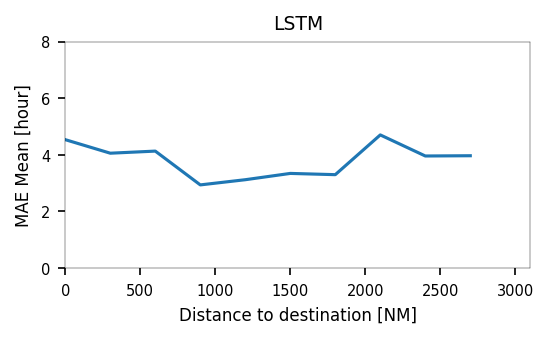

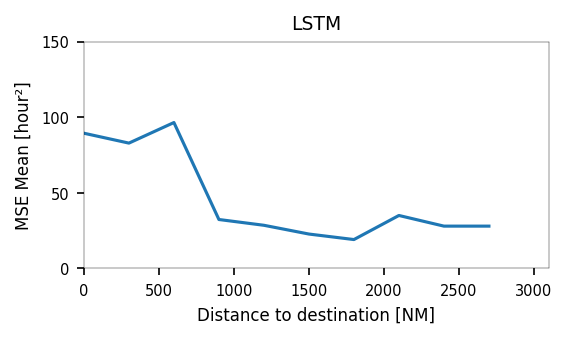

In [19]:
#plot MAE MSE per distance interval
#LSTM
l = [i for i in np.arange(0,3000,300)]
data_mae_lstm3 = {'mae': lstm3_mae_obs[1], 'distance': distance_seq_rev_test}
data_mse_lstm3 = {'mse': lstm3_mse_obs[1], 'distance': distance_seq_rev_test}
df_mae_lstm3 = pd.DataFrame(data=data_mae_lstm3)
df_mse_lstm3 = pd.DataFrame(data=data_mse_lstm3)

mae_mean_lstm3=[]
for i in l:
  m = df_mae_lstm3[(int(i) <= df_mae_lstm3['distance']) & (df_mae_lstm3['distance'] < int(i)+300)].mae.mean()
  mae_mean_lstm3.append(m)

mse_mean_lstm3=[]
for i in l:
  m = df_mse_lstm3[(int(i) <= df_mse_lstm3['distance']) & (df_mse_lstm3['distance'] < int(i)+300)].mse.mean()
  mse_mean_lstm3.append(m)

plt.figure(figsize=[4, 2],dpi= 150)
for axis in ['top','bottom','left','right']:
  plt.gca().spines[axis].set_linewidth(0.2)
plt.plot(l, mae_mean_lstm3)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('Distance to destination [NM]', fontsize = 8)
plt.ylabel('MAE Mean [hour]', fontsize = 8)
plt.title('LSTM', fontsize = 9)
lims_x = [0, 3100]
lims_y = [0, 8]
plt.xlim(lims_x)
plt.ylim(lims_y)
plt.show()

plt.figure(figsize=[4, 2],dpi= 150)
for axis in ['top','bottom','left','right']:
  plt.gca().spines[axis].set_linewidth(0.2)
plt.plot(l, mse_mean_lstm3)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('Distance to destination [NM]', fontsize = 8)
plt.ylabel('MSE Mean [hour²]', fontsize = 8)
plt.title('LSTM', fontsize = 9)
lims_x = [0, 3100]
lims_y = [0, 150]
plt.xlim(lims_x)
plt.ylim(lims_y) 
plt.show()

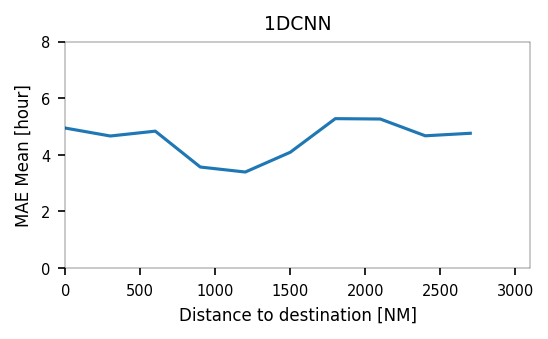

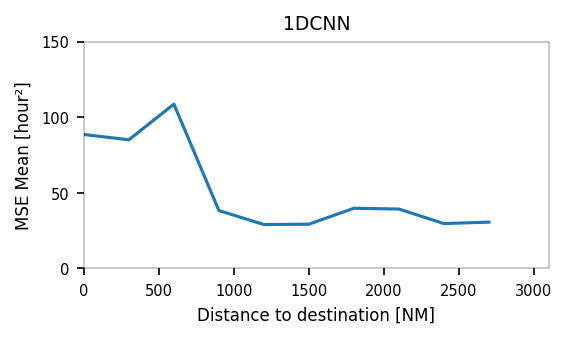

In [20]:
#plot MAE MSE per distance interval
#1DCNN
data_mae_cnn3 = {'mae': cnn3_mae_obs[1], 'distance': distance_seq_rev_test}
data_mse_cnn3 = {'mse': cnn3_mse_obs[1], 'distance': distance_seq_rev_test}
df_mae_cnn3 = pd.DataFrame(data=data_mae_cnn3)
df_mse_cnn3 = pd.DataFrame(data=data_mse_cnn3)

mae_mean_cnn3=[]
for i in l:
  m = df_mae_cnn3[(int(i) <= df_mae_cnn3['distance']) & (df_mae_cnn3['distance'] < int(i)+300)].mae.mean()
  mae_mean_cnn3.append(m)

mse_mean_cnn3=[]
for i in l:
  m = df_mse_cnn3[(int(i) <= df_mse_cnn3['distance']) & (df_mse_cnn3['distance'] < int(i)+300)].mse.mean()
  mse_mean_cnn3.append(m)

plt.figure(figsize=[4, 2],dpi= 150)
for axis in ['top','bottom','left','right']:
  plt.gca().spines[axis].set_linewidth(0.2)
plt.plot(l, mae_mean_cnn3)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('Distance to destination [NM]', fontsize = 8)
plt.ylabel('MAE Mean [hour]', fontsize = 8)
plt.title('1DCNN', fontsize = 9)
lims_x = [0, 3100]
lims_y = [0, 8]
plt.xlim(lims_x)
plt.ylim(lims_y)
plt.show()  

plt.figure(figsize=[4, 2],dpi= 150)
for axis in ['top','bottom','left','right']:
  plt.gca().spines[axis].set_linewidth(0.2)
plt.plot(l, mse_mean_cnn3)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('Distance to destination [NM]', fontsize = 8)
plt.ylabel('MSE Mean [hour²]', fontsize = 8)
plt.title('1DCNN', fontsize = 9)
lims_x = [0, 3100]
lims_y = [0, 150]
plt.xlim(lims_x)
plt.ylim(lims_y)
plt.show()

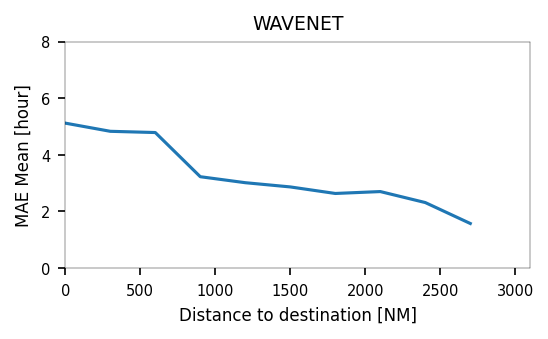

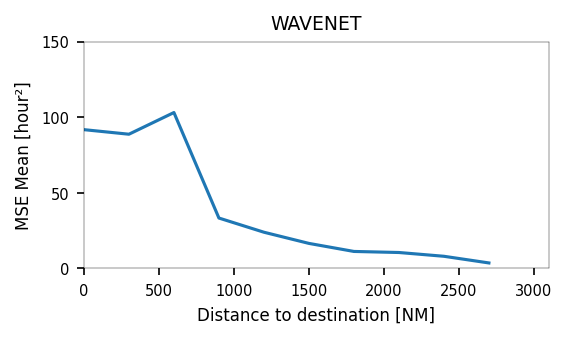

In [21]:
#plot MAE MSE per distance interval
#WAVENET
data_mae_wavenet3 = {'mae': wavenet3_mae_obs[1], 'distance': distance_seq_rev_test}
data_mse_wavenet3 = {'mse': wavenet3_mse_obs[1], 'distance': distance_seq_rev_test}
df_mae_wavenet3 = pd.DataFrame(data=data_mae_wavenet3)
df_mse_wavenet3 = pd.DataFrame(data=data_mse_wavenet3)

mae_mean_wavenet3=[]
for i in l:
  m = df_mae_wavenet3[(int(i) <= df_mae_wavenet3['distance']) & (df_mae_wavenet3['distance'] < int(i)+300)].mae.mean()
  mae_mean_wavenet3.append(m)

mse_mean_wavenet3=[]
for i in l:
  m = df_mse_wavenet3[(int(i) <= df_mse_wavenet3['distance']) & (df_mse_wavenet3['distance'] < int(i)+300)].mse.mean()
  mse_mean_wavenet3.append(m)

plt.figure(figsize=[4, 2],dpi= 150)
for axis in ['top','bottom','left','right']:
  plt.gca().spines[axis].set_linewidth(0.2)
plt.plot(l, mae_mean_wavenet3)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('Distance to destination [NM]', fontsize = 8)
plt.ylabel('MAE Mean [hour]', fontsize = 8)
plt.title('WAVENET', fontsize = 9)
lims_x = [0, 3100]
lims_y = [0, 8]
plt.xlim(lims_x)
plt.ylim(lims_y)
plt.show()

plt.figure(figsize=[4, 2],dpi= 150)
for axis in ['top','bottom','left','right']:
  plt.gca().spines[axis].set_linewidth(0.2)
plt.plot(l, mse_mean_wavenet3)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('Distance to destination [NM]', fontsize = 8)
plt.ylabel('MSE Mean [hour²]', fontsize = 8)
plt.title('WAVENET', fontsize = 9)
lims_x = [0, 3100]
lims_y = [0, 150]
plt.xlim(lims_x)
plt.ylim(lims_y)
plt.show()

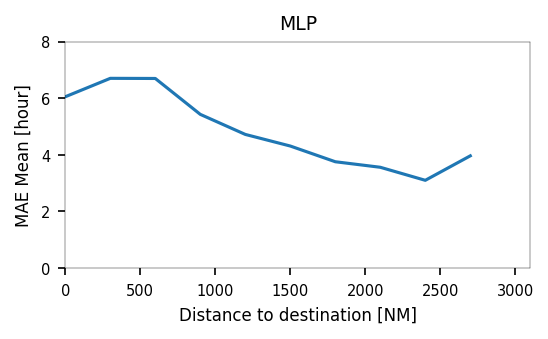

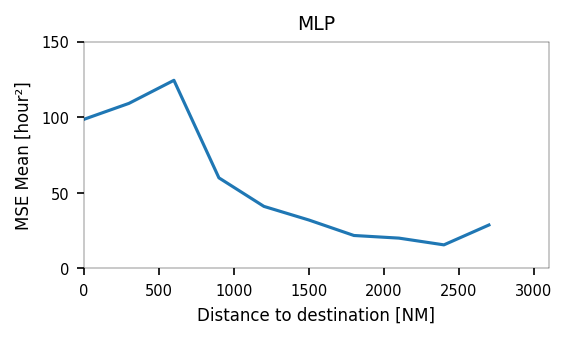

In [22]:
#plot MSE per distance interval
#MLP
data_mae_mlp3 = {'mae': mlp3_mae.reshape((39777,)), 'distance': distance_nn_seq_rev_test}
data_mse_mlp3 = {'mse': mlp3_mse.reshape((39777,)), 'distance': distance_nn_seq_rev_test}
df_mae_mlp3 = pd.DataFrame(data=data_mae_mlp3)
df_mse_mlp3 = pd.DataFrame(data=data_mse_mlp3)

mae_mean_mlp3=[]
for i in l:
  m = df_mae_mlp3[(int(i) <= df_mae_mlp3['distance']) & (df_mae_mlp3['distance'] < int(i)+300)].mae.mean()
  mae_mean_mlp3.append(m)

mse_mean_mlp3=[]
for i in l:
  m = df_mse_mlp3[(int(i) <= df_mse_mlp3['distance']) & (df_mse_mlp3['distance'] < int(i)+300)].mse.mean()
  mse_mean_mlp3.append(m)  

plt.figure(figsize=[4, 2],dpi= 150)
for axis in ['top','bottom','left','right']:
  plt.gca().spines[axis].set_linewidth(0.2)
plt.plot(l, mae_mean_mlp3)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('Distance to destination [NM]', fontsize = 8)
plt.ylabel('MAE Mean [hour]', fontsize = 8)
plt.title('MLP', fontsize = 9)
lims_x = [0, 3100]
lims_y = [0, 8]
plt.xlim(lims_x)
plt.ylim(lims_y)
plt.show()

plt.figure(figsize=[4, 2],dpi= 150)
for axis in ['top','bottom','left','right']:
  plt.gca().spines[axis].set_linewidth(0.2)
plt.plot(l, mse_mean_mlp3)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('Distance to destination [NM]', fontsize = 8)
plt.ylabel('MSE Mean [hour²]', fontsize = 8)
plt.title('MLP', fontsize = 9)
lims_x = [0, 3100]
lims_y = [0, 150]
plt.xlim(lims_x)
plt.ylim(lims_y)
plt.show()